<a href="https://colab.research.google.com/github/lanyu0322/phd_semester1/blob/master/read_multi_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import time
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter as uf
from scipy.optimize import least_squares

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [7, 5]
import glob

# Define 4 pop model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# -- read in the average weekend counts
fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                     "avg_weekend_ts.feather")
weekend = uf(pd.read_feather(fname)["avg_counts"].values, 8)

In [0]:
# -- read temp and humidity data
tname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "temp_humidity.csv")
temp = pd.read_csv(tname)

In [0]:
# -- define gaussian
def gauss(xarr, x0, sig, scl):
  """ Create a 1D Gaussian """
  
  amp = scl / (sig * np.sqrt(2.0 * np.pi))
  val = -0.5 * ((xarr - x0) / sig)**2
  
  return amp * np.exp(val)


# -- define the model
def pop_model(param, xval):

  # -- determine which model is being used from length of param array
  nparam = len(param)

  # -- 3 population model
  if nparam == 10:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, off = param
    wamp = 0.0

  # -- 4 population model
  elif nparam == 11:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = param

  # -- ill-defined param array
  else:
    print("Nparam must be 10 (3pop) or 11 (4pop) model!")
    return None

  model = gauss(xval, m1, sd1, scl1) + gauss(xval, m2, sd2, scl2) + \
    gauss(xval, m3, sd3, scl3) + wamp * wendvals + off

  return model


# -- define model error
def res(param, xval, yval):

  return yval - pop_model(param, xval)

In [0]:
# -- set inital guess
avgs  = [35, 47, 70] 
sigs  = [3, 3, 3]
scls  = [5, 5, 5]
off   = [0.5]
wamp = [6]
param = avgs + sigs + scls + wamp + off

# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]

# calculating average counts first and then average sratio

In [0]:
# -- read multi_files and combine them together
path = r'drive/My Drive/lwir/data/nycdot/counts_wd_cam'
all_files = glob.glob(path + "/*.feather")

li = []

for filename in all_files:
    df = pd.read_feather(filename)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [9]:
# -- create day and time column
frame["day"] = frame["date"].dt.date
frame["time"] = frame["date"].dt.time
frame

,date,count,day,time
0,2017-06-28 00:00:00,0.250000,2017-06-28,00:00:00
1,2017-06-28 00:15:00,0.181818,2017-06-28,00:15:00
2,2017-06-28 00:30:00,0.000000,2017-06-28,00:30:00
3,2017-06-28 00:45:00,0.181818,2017-06-28,00:45:00
4,2017-06-28 01:00:00,0.083333,2017-06-28,01:00:00
...,...,...,...,...
466843,2017-09-11 22:45:00,2.000000,2017-09-11,22:45:00
466844,2017-09-11 23:00:00,2.000000,2017-09-11,23:00:00
466845,2017-09-11 23:15:00,2.000000,2017-09-11,23:15:00
466846,2017-09-11 23:30:00,2.000000,2017-09-11,23:30:00


In [0]:
# -- camculating average counts in time series
ff = frame.groupby("day")

#testing...
# idx = 0
# for ind, gp in ff:
#   if (idx > 0):
#     break
#   print(ind, "\n", gp)
#   row_group = gp.groupby("time")
#   for ind2, gp2 in row_group:
#     print(ind2, "\n", gp2)
#     print(gp2["count"].mean())
#   idx = 1
#ok, let's write code 

avg_frame = []
for ind, gp in ff:
  row = []
  time_group = gp.groupby("time")
  for ind2, gp2 in time_group:
    time_mean = gp2["count"].mean()
    row.append(time_mean)
  avg_frame.append(row)


In [11]:
# -- create a avg dataframe
avg_frame_df = pd.DataFrame(avg_frame).T
avg_frame_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0.712266,0.658501,0.723379,0.793892,0.685281,0.657832,0.639423,0.651612,0.724812,0.659284,0.682397,0.686306,0.714293,0.679647,0.586759,0.686692,0.727852,0.649682,0.421193,0.598485,0.657537,0.754459,0.636412,0.525069,0.315914,0.735090,0.760085,0.580004,0.306746,0.745947,0.640862
1,0.678440,0.575494,0.638494,0.693900,0.632520,0.568705,0.584813,0.630718,0.662324,0.557035,0.603986,0.616918,0.640948,0.657595,0.535177,0.589848,0.673760,0.589027,0.424821,0.587338,0.653079,0.679618,0.559392,0.479504,0.303813,0.653108,0.678344,0.420913,0.360741,0.763993,0.595705
2,0.579145,0.538339,0.569908,0.636998,0.937500,0.542612,0.546926,0.576037,0.564466,0.508830,0.568037,0.587001,0.588931,0.494296,0.470083,0.543476,0.582407,0.499855,0.385466,0.538178,0.579936,0.633121,0.520639,0.403605,0.265783,0.611668,0.593997,0.494171,0.301872,0.680853,0.544341
3,0.507479,0.457170,0.491630,0.546750,0.514617,0.465155,0.461580,0.471048,0.542752,0.460963,0.469938,0.487937,0.526250,0.474571,0.434569,0.477514,0.525285,0.440021,0.367304,0.465026,0.567516,0.547134,0.517240,0.401029,0.239956,0.528566,0.614264,0.483015,0.319581,0.591585,0.467990
4,0.470517,0.430892,0.506369,0.495019,0.487179,0.429775,0.448718,0.436933,0.516503,0.444509,0.449334,0.416763,0.482822,0.451892,0.423663,0.490832,0.500724,0.413781,0.349498,0.450492,0.491932,0.483121,0.463869,0.392659,0.244692,0.486248,0.429840,0.425159,0.336904,0.546902,0.462025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.918790,1.016332,1.030762,1.019398,0.969114,0.988588,0.992249,1.075806,1.034453,0.938680,0.993804,0.990272,0.865663,0.905713,0.926462,1.047829,0.961349,0.952471,0.915364,0.959873,0.986943,0.964331,0.878011,0.872853,1.016213,0.971917,1.158560,0.923470,1.014235,1.133082,1.165605
92,0.953005,0.944594,0.996693,0.935244,0.940171,0.914627,0.934674,0.968249,0.997636,0.917371,0.941054,0.969938,0.858811,0.898668,0.925883,0.979792,0.956669,0.867342,0.863868,0.921338,1.035350,0.966242,0.843289,0.852538,0.977321,1.006369,1.038410,0.875603,1.008927,1.118510,1.165605
93,0.841112,0.858618,0.807039,0.874831,0.807774,0.875340,0.894056,0.909622,0.915364,0.831017,0.858377,0.839558,0.778373,0.873963,0.841006,0.939027,0.827784,0.806891,0.797163,0.859236,0.960828,0.924204,0.760732,0.756032,0.845734,0.905182,0.924291,0.784260,0.946921,1.064611,1.165605
94,0.746897,0.784713,0.801527,0.807833,0.749466,0.775456,0.789423,0.777842,0.811668,0.747288,0.766454,0.773306,0.732445,0.824358,0.788593,0.824773,0.752065,0.744702,0.742077,0.822718,0.848195,0.843312,0.746941,0.679599,0.802567,0.883536,0.954497,0.756958,0.903011,1.017998,1.165605


In [0]:
# -- replace the nan to the average counts
fnan = avg_frame_df.ffill()
bnan = avg_frame_df.bfill()

camarr_nnan = 0.5*(fnan + bnan).T

In [0]:
# -- optimize
plsq = []
for ii in range(len(camarr_nnan)):
  #print("working on day {0}".format(ii))

  plsq.append(least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                            args=(xval_final, camarr_nnan.iloc[ii])))

In [0]:
# -- put fit results into DataFrame
result_vals = pd.DataFrame(plsq)["x"].values
pardf = pd.DataFrame(np.vstack(result_vals), 
                     columns=["m1", "m2", "m3", "sd1", "sd2", "sd3", 
                              "scl1", "scl2", "scl3", "wamp", "off"])

In [0]:
# -- calculate sratio 
pardf["sratio"] = pardf["scl2"] / (0.5 * (pardf["scl1"] + pardf["scl3"]))
pardf["temp"] = temp["temp"]
pardf["humidity"] = temp["humidity"]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


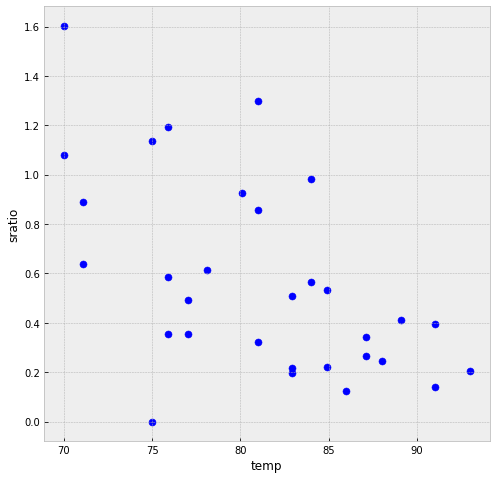

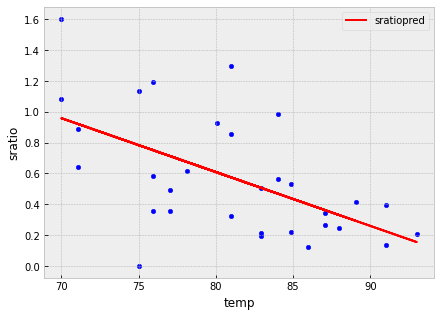

In [16]:
# -- create a scatter plot of temp and sratio
pardf.plot.scatter("temp", "sratio", figsize=[8, 8], vmax=2, s=50)
# -- create a linear prediction of restaurant and wamp plot
import statsmodels.formula.api as sm
sub = pardf.copy()
sub["sratiopred"] = sm.ols("sratio ~ temp", data=sub).fit().predict(sub)
ax = sub.plot.scatter("temp", "sratio")
sub.plot("temp", "sratiopred", c = "r", ax=ax)

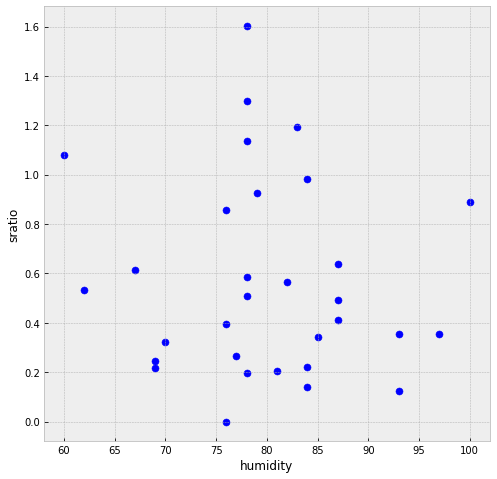

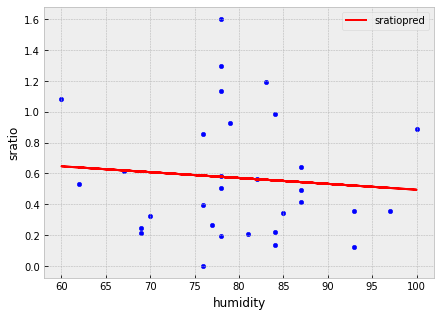

In [17]:
# -- create a scatter plot of humidity\t and sratio
pardf.plot.scatter("humidity", "sratio", figsize=[8, 8], vmax=2, s=50)
# -- create a linear prediction of restaurant and wamp plot
sub0 = pardf.copy()
sub0["sratiopred"] = sm.ols("sratio ~ humidity", data=sub0).fit().predict(sub0)
ax = sub0.plot.scatter("humidity", "sratio")
sub0.plot("humidity", "sratiopred", c = "r", ax=ax)

# calculate each sratio and then get mean sratio

In [0]:
# -- find cameras that less than 31 days
f = []
for i in range(157):
 ii = i*2976
 if frame["day"].iloc[ii] != "2017-06-28":
   f.append(frame.iloc[ii])

In [19]:
# -- test for f 
print(frame["day"].iloc[3])
print(frame["day"].iloc[3].strftime("%Y-%m-%d") != "2017-06-28")

2017-06-28
False


In [20]:
# -- 28 days camera counts
fc = frame.iloc[23808:26496] 
fr = fc.groupby("day").sum()
len(fr) #28days
fr

,count
day,
2017-06-28,312.046775
2017-06-29,298.220280
2017-06-30,172.718298
2017-07-05,272.515385
2017-07-12,268.907576
2017-07-13,273.810101
2017-07-17,188.005051
2017-07-18,198.456061
2017-07-19,198.116162


In [21]:
# -- 30 days camera counts
frame.iloc[127680] #130559
fc0 = frame.iloc[127680:130559] 
fr0 = fc0.groupby("day").sum()
len(fr0) #30days

30

In [0]:
# -- get the value of counts for each camera before 23808
f_23808 = frame.iloc[0:23808]


# -- define the value of 

count_23808 = []
nnan_23808 = []
data_23808 = []

for i in range(len(f_23808)):
   ii = i*2976
   jj = ii - 2976
   datagr = f_23808[jj:ii].groupby("day")
   for ind0, gr in datagr: # get the counts and replace teh nan to the average of counts
     count_23808.append(gr["count"].values)
     count_sub = pd.DataFrame(count_23808).T
     fnan = count_sub.ffill()
     bnan = count_sub.bfill()
     nnan_23808 = 0.5*(fnan + bnan).T
    #  for j in range(8): #len(nnan_23808)/31 = 8.0
    #    d = j*31
    #    jjj = d-31
    #    count_sub0 = nnan_23808[jjj:d]
    #    count_sub0["day"] = days
    #    data_23808.append(count_sub0)

In [0]:
# def calculate_sratio(f_23808):
#   for i in range(len(f_23808)):
#    ii = i*2976
#    jj = ii - 2976
#    datagr = f_23808[jj:ii].groupby("day")
#    for ind0, gr in datagr: # get the counts and replace teh nan to the average of counts
#      count_23808.append(gr["count"].values)
#      count_sub = pd.DataFrame(count_23808).T
#      fnan = count_sub.ffill()
#      bnan = count_sub.bfill()
#      nnan_23808 = 0.5*(fnan + bnan).T
#   return nnan_23808


In [23]:
nnan_23808

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,0.250000,0.181818,0.000000,0.181818,0.083333,0.000000,0.090909,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.181818,0.166667,0.000000,0.000000,0.000000,0.000000,0.333333,0.181818,0.900000,1.166667,2.083333,4.000000,2.833333,3.083333,3.545455,4.666667,6.000000,6.833333,8.636364,9.272727,8.583333,9.272727,11.166667,6.636364,5.833333,4.000000,...,9.083333,10.181818,8.916667,9.166667,8.818182,9.166667,7.583333,9.833333,9.090909,8.090909,7.888889,8.000000,11.666667,9.333333,10.583333,11.750000,7.916667,8.230769,9.333333,12.083333,6.500000,6.200000,6.666667,5.461538,6.500000,5.333333,5.583333,2.000000,1.083333,0.750000,0.615385,0.583333,0.166667,0.500000,0.083333,0.250000,0.500000,0.500000,0.153846,0.250000
1,0.000000,0.250000,0.333333,0.076923,0.250000,0.000000,0.000000,0.076923,0.083333,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.692308,0.416667,0.916667,1.384615,1.600000,1.666667,3.666667,3.538462,3.818182,3.083333,4.833333,5.363636,8.250000,7.800000,8.833333,8.000000,8.416667,4.000000,5.166667,7.500000,...,9.500000,9.846154,10.250000,10.636364,9.000000,12.333333,9.500000,10.750000,10.083333,9.083333,10.454545,8.000000,8.333333,11.333333,13.000000,10.923077,11.750000,10.666667,9.538462,8.461538,8.692308,9.666667,7.333333,7.051282,6.769231,5.230769,4.000000,2.000000,0.769231,0.307692,0.230769,0.307692,1.000000,0.250000,0.307692,0.250000,0.153846,0.181818,0.250000,0.500000
2,0.250000,0.333333,0.230769,0.166667,0.000000,0.000000,0.083333,0.083333,0.076923,0.083333,0.083333,0.076923,0.000000,0.000000,0.076923,0.000000,0.083333,0.000000,0.100000,0.000000,0.692308,0.666667,1.166667,0.846154,1.583333,2.666667,1.833333,2.307692,2.666667,3.250000,3.538462,6.166667,6.083333,6.285714,6.307692,10.076923,8.500000,7.230769,5.769231,6.230769,...,10.615385,8.846154,10.769231,9.384615,9.000000,7.000000,9.583333,11.153846,9.461538,7.636364,9.230769,11.000000,9.692308,8.727273,10.153846,9.692308,10.538462,9.153846,9.083333,7.769231,8.384615,5.307692,7.769231,4.461538,5.000000,2.692308,3.769231,1.000000,1.000000,1.230769,0.538462,0.769231,0.846154,0.500000,0.384615,0.076923,0.076923,0.083333,0.076923,0.250000
3,0.250000,0.166667,0.000000,0.000000,0.230769,0.083333,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.153846,0.000000,0.000000,0.000000,0.083333,0.384615,0.500000,1.416667,1.166667,2.000000,3.416667,1.538462,2.500000,3.250000,4.250000,3.666667,5.846154,6.166667,6.166667,7.769231,10.333333,10.333333,7.416667,7.583333,6.416667,...,9.500000,9.666667,10.083333,8.833333,9.250000,8.500000,8.416667,7.818182,9.000000,9.083333,8.500000,8.166667,9.090909,9.538462,8.250000,8.916667,10.100000,6.833333,7.083333,8.500000,10.230769,7.166667,5.583333,5.083333,4.416667,4.416667,4.636364,2.250000,0.750000,1.083333,0.615385,0.916667,0.250000,0.272727,0.333333,0.250000,0.000000,0.250000,0.090909,0.166667
4,0.250000,0.000000,0.000000,0.090909,0.000000,0.083333,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.166667,0.384615,0.750000,1.166667,1.416667,1.923077,2.363636,1.916667,4.166667,4.769231,4.250000,6.083333,6.416667,7.615385,9.833333,9.416667,11.000000,8.250000,6.416667,8.600000,...,10.769231,9.000000,7.750000,11.166667,9.181818,10.750000,10.250000,9.916667,13.250000,10.636364,9.916667,10.583333,12.166667,10.250000,11.333333,13.750000,8.333333,9.833333,9.583333,9.166667,8.666667,8.750000,6.916667,7.555556,5.166667,4.333333,4.583333,3.166667,1.333333,0.583333,0.583333,0.750000,0.250000,0.166667,0.250000,0.583333,0.000000,0.250000,0.000000,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [0]:
# -- get the value of counts for each camera before 23808

count_23808 = []
nnan_23808 = []
data_23808 = []

for i in range(len(fc)):
   datagr = fc[jj:ii].groupby("day")
   for ind0, gr in datagr: # get the counts and replace teh nan to the average of counts
     count_23808.append(gr["count"].values)
     count_sub = pd.DataFrame(count_23808).T
     fnan = count_sub.ffill()
     bnan = count_sub.bfill()
     nnan_23808 = 0.5*(fnan + bnan).T

In [0]:
# -- optimize
plsq_23808 = []
for ii in range(len(nnan_23808)):
  #print("working on day {0}".format(ii))

  plsq_23808.append(least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                            args=(xval_final, nnan_23808.iloc[ii])))


In [26]:
# -- put fit results into DataFrame
result_23808 = pd.DataFrame(plsq_23808)["x"].values
pardf_23808 = pd.DataFrame(np.vstack(result_23808), 
                     columns=["m1", "m2", "m3", "sd1", "sd2", "sd3", 
                              "scl1", "scl2", "scl3", "wamp", "off"])
# -- calculate sratio 
pardf_23808["sratio"] = pardf_23808["scl2"] / (0.5 * (pardf_23808["scl1"] + pardf_23808["scl3"]))

KeyError: ignored

In [0]:
# -- get the value of counts for each camera after 130560
f_466848 = frame.iloc[130560:466848]


# -- define the value of 

count_466848 = []
nnan_466848 = []
data_466848 = []

for i in range(len(f_466848)):
   ii = i*2976
   jj = ii - 2976
   datagr = f_466848[jj:ii].groupby("day")
   for ind0, gr in datagr: # get the counts and replace teh nan to the average of counts
     count_466848.append(gr["count"].values)
     count_sub = pd.DataFrame(count_466848).T
     fnan = count_sub.ffill()
     bnan = count_sub.bfill()
     nnan_466848 = 0.5*(fnan + bnan).T

In [0]:
# -- optimize
plsq_466848 = []
for ii in range(len(nnan_466848)):
  #print("working on day {0}".format(ii))

  plsq_466848.append(least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                            args=(xval_final, nnan_466848.iloc[ii])))


In [0]:
# -- put fit results into DataFrame
result_466848 = pd.DataFrame(plsq_466848)["x"].values
pardf_466848 = pd.DataFrame(np.vstack(result_466848), 
                     columns=["m1", "m2", "m3", "sd1", "sd2", "sd3", 
                              "scl1", "scl2", "scl3", "wamp", "off"])
# -- calculate sratio 
pardf_466848["sratio"] = pardf_466848["scl2"] / (0.5 * (pardf_466848["scl1"] + pardf_466848["scl3"]))

In [0]:
oname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "sratio_466848.csv")
pardf_466848.to_csv(oname, index=False)

In [0]:
oname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "sratio_23808.csv")
pardf_23808.to_csv(oname, index=False)

In [0]:
days

In [0]:
pardf_466848

In [0]:
pardf_23808

In [0]:
# -- add sratio of camera 175 and camera 409
# -- read temp and humidity data
cname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "cam175_sratio.csv")
cam175 = pd.read_csv(cname)

aname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "cam409_sratio.csv")
cam409 = pd.read_csv(aname)

In [0]:
cam409